In [5]:
import os
import sys
import time
import sqlite3
from Functions.database import createTable
import tensorboard as tf

import matplotlib.pyplot as plt

from envConfig import CONFIG
CONFIG["PACKAGE_NAME"] = os.path.join(CONFIG["OUTPUTDATAPATH"], "Classification")

from Functions.FunctionsDataVisualization import hist_csv, plotLOFARgram, plotConfusionMatrix

import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import confusion_matrix
from lps_toolbox.metrics.classification import sp_index

analysis_name = 'Classification'

data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


#db = sqlite3.connect(results_path+'classification.db')
#time = time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime())

In [6]:
from Functions.dataset.shipClasses import LoadData

dt_24 = LoadData(dev=False)
#dt_24.infoData()
all_data,all_trgt= dt_24.getData()

[+] Time to read data file: 3.0801589489 seconds


In [7]:
name = 'A'

folder = '/home/venancio/Workspace/SonarAnalysis/Results/Classification/Hierarq_spec_10_inits_10_folds_10_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_512_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss/'
folder_folds = folder + 'estimator_{0}/'.format(name)

if name=='super':
    name = 'S'
file = folder_folds + 'hierarq_analy_{0}_estimator.csv'.format(name)


In [8]:
def pred_true_df(df_tabela,ifold,colum=None):
   
    if colum is "wta":
        pred = df_tabela['ClassEspe_WTA(resultados)_{0}'.format(ifold)].values
    else:
        pred = df_tabela[u'HierarqNet(resultados)_{0}'.format(ifold)].values
    target = df_tabela['target_0'].values
    
    print target.shape, pred.shape
    
    return pred, target


def recall_df(df_tabela,ifold,colum=None):
    pred, trgt = pred_true_df(df_tabela,ifold,colum)
    
    return recall_score(y_true=true,y_pred=pred,average=None)

def SP_df(df_tabela,ifold,colum=None):
    #pred_wta = df_tabela[df_tabela['fold_{0}'.format(ifold)]==1]['ClassEspe_WTA(resultados)_{0}'.format(ifold)].values
    #target = df_tabela[df_tabela['fold_{0}'.format(ifold)]==1]['target'].values
    
    pred, trgt = pred_true_df(df_tabela,ifold,colum)
    
    return sp_index(y_pred=pred,y_true=trgt)


In [9]:
df = pd.read_csv(file)
print df.columns

fig = plt.figure(figsize=(10,5))
nbins = 20
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle(u"Distribuição da Saída do Classificador {0} por Fold".format(name), fontsize=14)
for idx in range(10):
    ax = plt.subplot(2,5, idx+1)
    sns.distplot(df[u'HierarqNet(valor)_{0}'.format(idx)].values,ax=ax,kde=False)#,bins=20)
    ax.grid()
    plt.title('fold {0}'.format(idx+1),fontsize=7)
    if (idx==0) | (idx==5):
        plt.ylabel(u'Densidade')
    
    plt.xlabel(u'Saída do Classificador')
    
    plt.savefig(folder_folds+'distribution_{0}_10folds.png'.format(name))

IOError: File /home/venancio/Workspace/SonarAnalysis/Results/Classification/Hierarq_spec_10_inits_10_folds_10_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_512_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss/estimator_A/hierarq_analy_A_estimator.csv does not exist

In [248]:
df.head()

,index,HierarqNet(resultados)_0,HierarqNet(valor)_0,fold_0,target_0,HierarqNet(resultados)_1,HierarqNet(valor)_1,fold_1,target_1,HierarqNet(resultados)_2,...,fold_7,target_7,HierarqNet(resultados)_8,HierarqNet(valor)_8,fold_8,target_8,HierarqNet(resultados)_9,HierarqNet(valor)_9,fold_9,target_9
0,36393,0,0.669678,1,0,0,0.830631,0,0,0,...,0,0,0,0.985410,0,0,0,0.695883,0,0
1,36394,0,0.964804,1,0,0,0.979662,0,0,0,...,0,0,0,0.989628,0,0,0,0.997449,0,0
2,36395,0,0.964809,1,0,0,0.979701,0,0,0,...,0,0,0,0.989948,0,0,0,0.998377,0,0
3,36396,0,0.963269,1,0,0,0.979718,0,0,0,...,0,0,0,0.989934,0,0,0,0.996140,0,0
4,36397,0,0.964768,1,0,0,0.979545,0,0,0,...,0,0,0,0.989926,0,0,0,0.998377,0,0


(988,) (988,)
(987,) (987,)
(986,) (986,)
(986,) (986,)
(985,) (985,)
(985,) (985,)
(985,) (985,)
(985,) (985,)
(985,) (985,)
(985,) (985,)


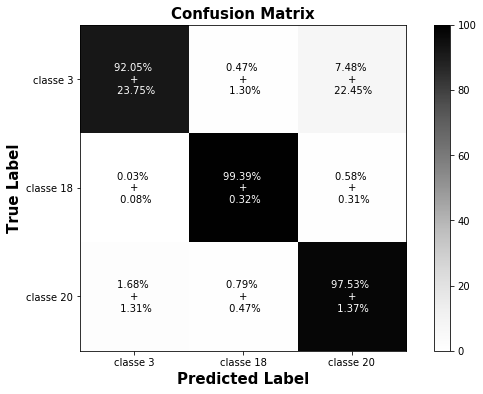

In [276]:
#analise para os valores de -1 a -0.5 com o conjunto de teste

limiar_superior = 1
limiar_inferior = -1
cm_folds=[]
#print("all shape: {0}".format(df[df['fold_{0}'.format(0)] == 1].shape))
#fig = plt.figure(figsize=(15,15))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)
for ifold in range(10):
    #ax = plt.subplot(5,2, ifold+1)
#    print("number of samples below {0}: {1}".format(limiar,df[(df[u'HierarqNet(valor)_{0}'.format(ifold)] <= limiar)].shape))
    df_neg = df[(df[u'HierarqNet(valor)_{0}'.format(ifold)] <= limiar_superior) & (df[u'HierarqNet(valor)_{0}'.format(ifold)] >= limiar_inferior) & (df[u'fold_{0}'.format(ifold)] == 1)]
    pred, true = pred_true_df(df_neg,ifold)
#    print SP_df(df_neg,ifold)
#    print np.unique(true)
    confusionMatrix = confusion_matrix(true, pred)
    cm = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    cm_folds.append(cm)
    
    #plotConfusionMatrix(trgt=true,predictions=pred,class_labels=[i for i in range(6)],ax=ax)
    #for iclass in range(24):
    #    df_target = df_neg[(df_neg['ClassEspe(resultados)_{0}'.format(ifold)]  == df_neg["target"])&(df_neg["target"]==i)]#&(df_neg["target"]==2)]
    #    print("fold {0},class {1} : qtd {2}".format(ifold+1,iclass+1,df_target.shape[0]))
cm_3 = np.array(cm_folds)
cm_mean = cm_3.mean(axis=0)
cm_std = cm_3.std(axis=0)

classes = ['3','18','20']

iris_labels = ['classe {0}'.format(i) for i in classes]

cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm_mean
cm_norm_std = 100.*cm_std

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('{0:1.2f}% \n+\n {1:1.2f}%'.format(cm_normalized[x][y], cm_norm_std[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('{0:1.2f}% \n+\n {1:1.2f}%'.format(cm_normalized[x][y], cm_norm_std[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(iris_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(iris_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(iris_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(folder_folds+'confusion_matrix_{0}_{1}.png'.format(limiar_inferior,limiar_superior))

In [183]:
cm_3 = np.array(cm_folds)
cm_mean = cm_3.mean(axis=0)
cm_std = cm_3.std(axi)

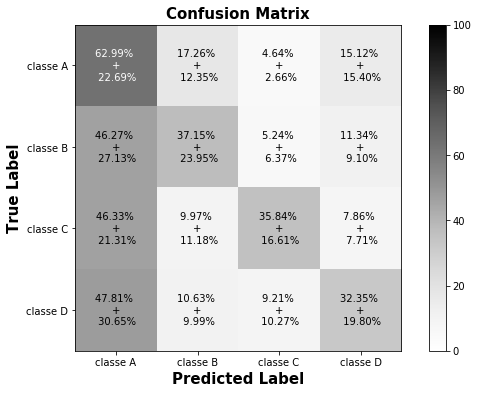

In [184]:
iris_labels = ['classe {0}'.format(i) for i in ['A','B','C','D']]

cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm_mean
cm_norm_std = 100.*cm_std

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape

for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('{0:1.2f}% \n+\n {1:1.2f}%'.format(cm_normalized[x][y], cm_norm_std[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('{0:1.2f}% \n+\n {1:1.2f}%'.format(cm_normalized[x][y], cm_norm_std[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(iris_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(iris_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(iris_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
plt.savefig(folder_folds+'confusion_matrix_0_05.png')

# Histograma (saída de cada classe) X (Classe)

In [39]:
#classe A

class_folder = '/home/venancio/Workspace/SonarAnalysis/Results/Classification/Hierarq_10_inits_10_folds_10_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_32_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss/estimator_A'
fold_folder = class_folder + '/fold00'
output_sparce_csv = fold_folder + '/output_sparce.csv'
hierarq_anal_csv = fold_folder + '/hierarq_analy_fold_0.csv'

In [40]:
df_output = pd.read_csv(output_sparce_csv,names=['neuronio_{0}'.format(i) for i in range(3)])
df_trgt = pd.read_csv(hierarq_anal_csv)['target_0'].values

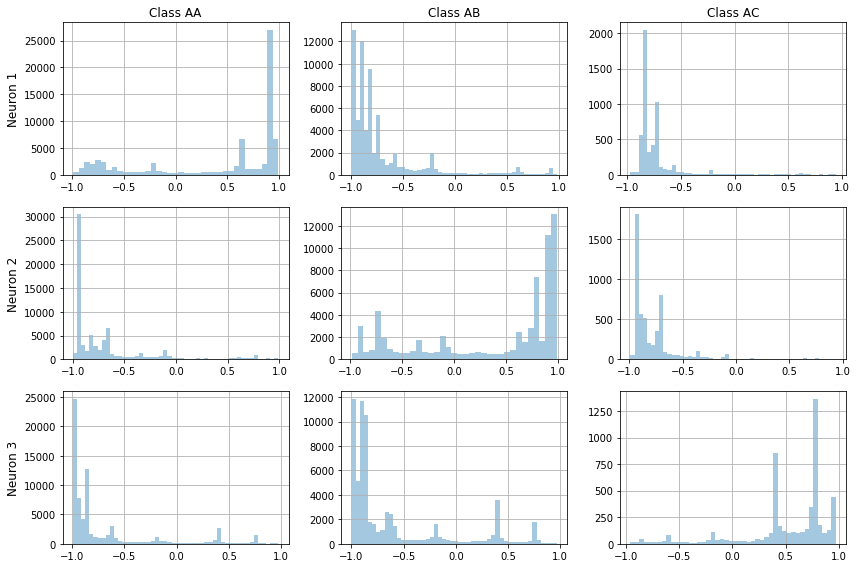

In [41]:
from scipy.stats import norm

#fig = plt.figure(figsize=(10,5))

#ax = plt.subplot(3,3, pos_plot+1)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
nbins = 20
fig.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=0.4)
#fig.suptitle(u"Distribuição da Saída do Classificador {0} por Fold".format(name), fontsize=14)

cols = ['Class {}'.format(col) for col in ['AA','AB','AC']]
rows = ['Neuron {}'.format(row) for row in range(1,4)]

pos_plot = 0
for n_col, icolumn in enumerate(df_output.columns):
    for n_row, iclass in enumerate(np.unique(df_trgt)):
        #ax = plt.subplot(3,3, pos_plot+1)
        ax = axes[n_col][n_row]
        neuron_output = df_output[icolumn].values
        values = neuron_output[df_trgt==iclass]
        sns.distplot(values,ax=ax,kde=False)
        
        ax.grid()
        pos_plot = pos_plot+1
        
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
    
fig.tight_layout()

In [30]:
for i in np.unique(df_trgt):
    print(sum(df_trgt==i))

73875
68060
5292


In [34]:
teste = np.random.random(size=(5,5))
teste

array([[0.77198723, 0.14784808, 0.08051029, 0.41840492, 0.28165166],
       [0.52058174, 0.19653261, 0.53006879, 0.11085495, 0.48912722],
       [0.79637783, 0.49609804, 0.2310905 , 0.5983069 , 0.34769679],
       [0.48826337, 0.07065136, 0.96843919, 0.20168291, 0.80449377],
       [0.92264643, 0.26390101, 0.72638717, 0.21863445, 0.23813108]])

In [37]:
teste[:,0]

array([0.77198723, 0.52058174, 0.79637783, 0.48826337, 0.92264643])